# Explaining K-Means with NEON
This demo demonstrates the NEON approach for explaining K-Means clustering predictions. The method is fully described in

<blockquote>
Kauffmann, J., Esders, M., Ruff, L., Montavon, G., Samek, W., & Müller, K.-R.<br><a href="https://arxiv.org/abs/1906.07633v2">From clustering to cluster explanations via neural networks</a><br><font color="#008800">arXiv:1906.07633v2., 2021</font>
</blockquote>

In [1]:
from kmeans import KMeans
from neon import NeuralizedKMeans, neon
from utils import *

## Loading the data
First, we load the dataset and normalize the data to a reasonable range.

In [2]:
wine = load_wine()
X, ytrue = wine['data'], tr.tensor(wine['target'])
feature_names = wine['feature_names']

X = MinMaxScaler().fit_transform(X)
X = tr.from_numpy(X)

## Training the K-Means model
Then, we train a K-Means model.

In [3]:
# random state for reproducibility
m = KMeans(n_clusters=3, random_state=77)
m.fit(X)

The cluster assignments and true labels can be visualized in a 2D PCA embedding.

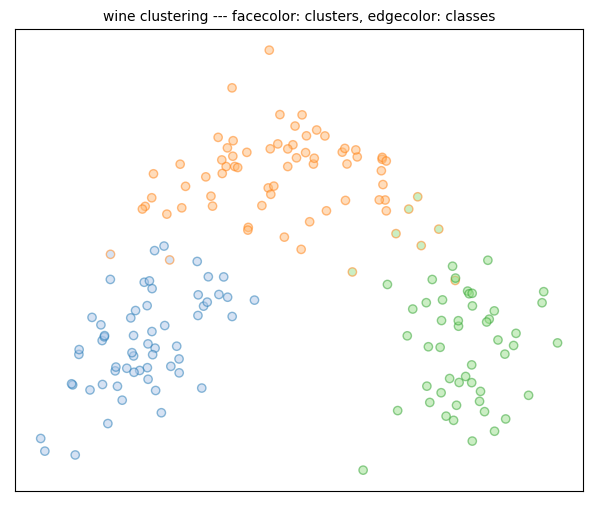

In [4]:
# find best match between clusters and classes
y = m.decision(X)
C = contingency_matrix(ytrue, y)
_, best_match = linear_sum_assignment(-C.T)
y = tr.tensor([best_match[i] for i in y])

# compute a PCA embedding for visualization
pca = PCA(n_components=2).fit(X)
Z = pca.transform(X)

plt.title('wine clustering --- facecolor: clusters, edgecolor: classes')
plt.scatter(Z[:,0], Z[:,1], facecolor=cmap(2*y.numpy() + 1), edgecolor=cmap(2*ytrue.numpy()), alpha=.5)
plt.gca().set_aspect('equal')
plt.xticks([]), plt.yticks([])
plt.show()

## Neuralizing the model

The decision function for a cluster can be recoved as
$$
f_c(\boldsymbol{x}) = \min_{k\neq c}\left\lbrace \|\boldsymbol{x} - \boldsymbol{\mu}_k\|^2 \right\rbrace - \|\boldsymbol{x} - \boldsymbol{\mu}_k\|^2
$$
This function contrasts distance to cluster $c$ against distance to the nearest competitor.

In [5]:
logits = m(X)

As shown in the original paper, the logit can be transformed to a neural network with identical outputs. The layers can be described as
$$\begin{align}
h_k &= \boldsymbol{w}_{k}^\top\boldsymbol{x} + b_{k} &&\text{(layer 1)}\\
f_c &= \min_{k\neq c} \left\lbrace h_k \right\rbrace &&\text{(layer 2)}
\end{align}$$

In [6]:
m = NeuralizedKMeans(m)

# check if all outputs are exactly the same with the neuralized model
assert tr.isclose(logits, m(X)).all(), "Predictions are not equal!"

## Explaining the cluster assignment

The neuralized model can be explained with Layer-wise Relevance Propagation (LRP). Here, we use the midpoint-rule in the first layer as described in the paper.

$$\begin{align}
R_k &= \frac{\exp(-\beta h_k)}{\sum_{k'\neq c}\exp(-\beta h_{k'})}f_c \\
R_i &= \sum_{k\neq c}\frac{(x_i - m_{ik})\cdot w_{ik}}{\sum_i (x_i - m_{ik})\cdot w_{ik}} R_k
\end{align}$$
with $R_i$ the relevance of input $x_i$. The hyperparameter $\beta$ controls the contribution of other competitors to the explanation. The main purpose is to disambiguate the explanation when more than one competitor is close to the min in layer 2.

In [7]:
R = neon(m, X, beta=1)

The explanations can be visualized similarly to the inputs, e.g. in a barplot.
Here, we show an explanation for all misclassified points.

Note that points near the decision boundary (with probability close to 0.5) have low ambiguity regarding the nearest competitors, hence $\beta$ has little effect.

data point 60
  cluster assignment: 2 (probability 0.52)
  true class        : 1
  sum(R) / logit    : 0.0772 / 0.0772


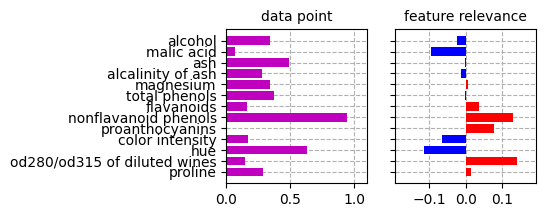

--------------------------------------------------------------------------------
data point 61
  cluster assignment: 2 (probability 0.56)
  true class        : 1
  sum(R) / logit    : 0.2447 / 0.2447


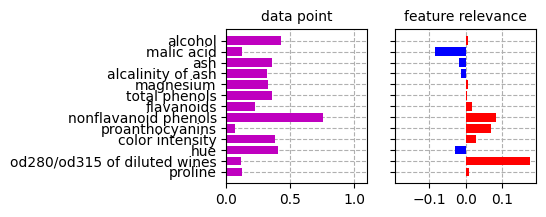

--------------------------------------------------------------------------------
data point 68
  cluster assignment: 2 (probability 0.52)
  true class        : 1
  sum(R) / logit    : 0.0800 / 0.0800


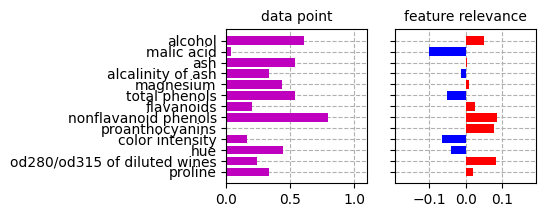

--------------------------------------------------------------------------------
data point 70
  cluster assignment: 2 (probability 0.52)
  true class        : 1
  sum(R) / logit    : 0.0866 / 0.0866


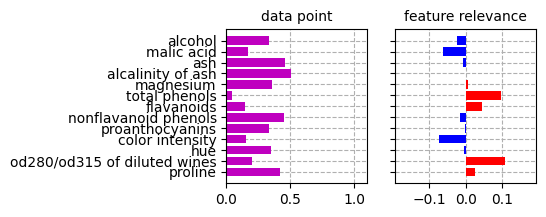

--------------------------------------------------------------------------------
data point 73
  cluster assignment: 0 (probability 0.57)
  true class        : 1
  sum(R) / logit    : 0.2848 / 0.2848


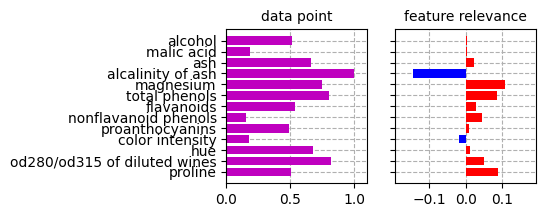

--------------------------------------------------------------------------------
data point 83
  cluster assignment: 2 (probability 0.61)
  true class        : 1
  sum(R) / logit    : 0.4378 / 0.4378


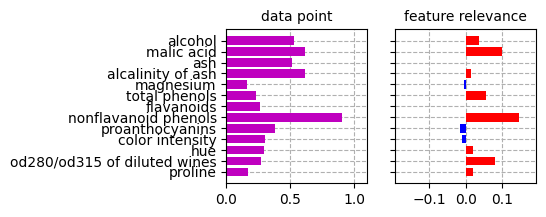

--------------------------------------------------------------------------------
data point 92
  cluster assignment: 2 (probability 0.50)
  true class        : 1
  sum(R) / logit    : 0.0089 / 0.0089


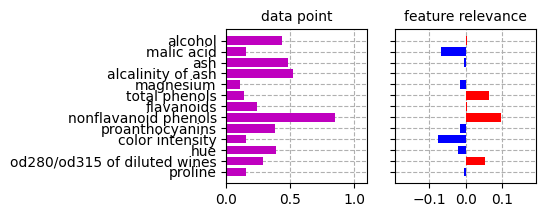

--------------------------------------------------------------------------------
data point 95
  cluster assignment: 0 (probability 0.53)
  true class        : 1
  sum(R) / logit    : 0.1348 / 0.1348


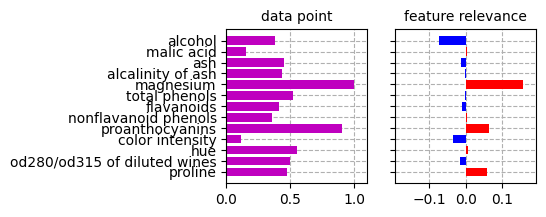

--------------------------------------------------------------------------------
data point 118
  cluster assignment: 2 (probability 0.55)
  true class        : 1
  sum(R) / logit    : 0.2151 / 0.2151


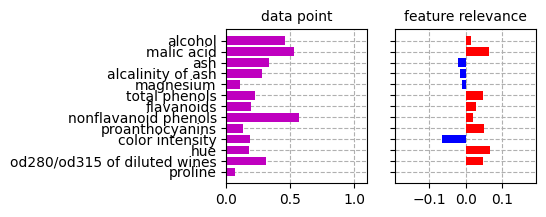

--------------------------------------------------------------------------------


In [8]:
I = tr.nonzero(y != ytrue)[:,0]
for i in I:
    logit = logits[i]
    prob = 1 / (1 + tr.exp(-logit))

    print('data point %d'%i)
    print('  cluster assignment: %d (probability %.2f)'%(y[i],prob))
    print('  true class        : %d'%ytrue[i])
    print('  sum(R) / logit    : %.4f / %.4f'%(sum(R[i]), logit))
    plot_explanation(X[i], R[i], feature_names, vlim=abs(R[I]).max()*1.1)
    plt.show()
    print('-'*80)